# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings
import string

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
%matplotlib inline

In [5]:
font = {"family": 'Arial'}
        #'size'   : 18}
#        'weight' : 'bold',}

matplotlib.rc('font', **font)

In [6]:
import spikeinterface

In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_2730888/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import spikeinterface.full as si

# Plotting Configurations

In [11]:
size_ratio = 1

In [12]:
# Plot Specifics
TITLESIZE = 60 * size_ratio
AXESLABEL = 60 * size_ratio
AXESTICKS = 45 * size_ratio
MARKERSIZE = 300 * size_ratio
LINWID = 5
DOTS = 25 * size_ratio
LEGSIZE = 40 * size_ratio

# Getting average firing rate from all sessions

In [13]:
all_neuron_to_bin_firing_rate_path = glob.glob("./**/proc/*neuron_to_bin_firing_rate_df.csv", recursive=True)

In [14]:
all_neuron_to_bin_firing_rate_path

['./subject_6_3/20221215/proc/20221215_145401_comp_amd_om_6_3_top_1_base_2_vs_6_3_neuron_to_bin_firing_rate_df.csv',
 './subject_6_3/20221214/proc/20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1_neuron_to_bin_firing_rate_df.csv',
 './subject_6_1/20221215/proc/20221215_145401_comp_amd_om_6_1_top_4_base_3_neuron_to_bin_firing_rate_df.csv',
 './subject_6_1/20221214/proc/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3_neuron_to_bin_firing_rate_df.csv']

In [15]:
all_neuron_to_bin_firing_rate_df = [pd.read_csv(path, index_col=0) for path in all_neuron_to_bin_firing_rate_path]

In [16]:
all_neuron_to_bin_firing_rate_df[0].columns.difference(all_neuron_to_bin_firing_rate_df[1].columns)

Index(['-10.0 loss', '-10.0 omission', '-10.0 rewarded', '-10.0 win'], dtype='object')

In [17]:
pivoted_averaged_firing_rate_df = pd.concat(all_neuron_to_bin_firing_rate_df).reset_index(drop=True)
pivoted_averaged_firing_rate_df = pivoted_averaged_firing_rate_df.fillna(value=0)

- So that we can avoid using the subject id and recording date

In [18]:
dropped_pivoted_averaged_firing_rate_df = pivoted_averaged_firing_rate_df.drop(columns=["subject_id", "recording_date"])

- Turning the dataframe into an array to be usable

In [19]:
resetted_averaged_firing_rate_array = dropped_pivoted_averaged_firing_rate_df.values

In [20]:
resetted_averaged_firing_rate_array[:5]

array([[0.33333333, 0.        , 0.5       , ..., 0.33333333, 0.        ,
        0.        ],
       [0.11111111, 0.        , 0.        , ..., 0.        , 0.2       ,
        0.        ],
       [0.5       , 0.5       , 0.16666667, ..., 0.        , 0.3       ,
        1.        ],
       [0.11111111, 0.        , 0.        , ..., 0.33333333, 0.        ,
        0.        ],
       [2.33333333, 0.        , 2.33333333, ..., 1.66666667, 1.2       ,
        1.        ]])

# PCA with Neuron Rows

## Standarizing the Data

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
dropped_pivoted_averaged_firing_rate_df.head()

,-0.1 loss,-0.1 omission,-0.1 rewarded,-0.1 win,-0.2 loss,-0.2 omission,-0.2 rewarded,-0.2 win,-0.3 loss,-0.3 omission,...,9.7 rewarded,9.7 win,9.8 loss,9.8 omission,9.8 rewarded,9.8 win,9.9 loss,9.9 omission,9.9 rewarded,9.9 win
0,0.333333,0.0,0.500000,0.0,0.111111,0.0,0.5,1.0,0.111111,0.0,...,0.000,0.0,0.333333,0.666667,0.000,0.0,0.222222,0.333333,0.0,0.0
1,0.111111,0.0,0.000000,0.0,0.222222,0.0,0.1,0.0,0.111111,0.0,...,0.000,0.0,0.222222,0.000000,0.125,0.0,0.166667,0.000000,0.2,0.0
2,0.500000,0.5,0.166667,0.0,0.166667,1.0,0.2,0.0,0.166667,0.0,...,0.125,0.0,0.277778,0.666667,0.000,0.0,0.388889,0.000000,0.3,1.0
3,0.111111,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.277778,0.0,...,0.125,0.0,0.166667,0.000000,0.250,0.0,0.111111,0.333333,0.0,0.0
4,2.333333,0.0,2.333333,0.0,2.777778,0.0,1.7,3.0,2.111111,0.5,...,0.750,0.0,2.166667,1.333333,1.250,0.0,2.166667,1.666667,1.2,1.0


In [23]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [24]:
from sklearn.decomposition import PCA


- Getting the PC Coeffecients

In [25]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [26]:
principal_df.head()

,principal component 1,principal component 2
0,-0.280335,3.085513
1,-14.507755,0.987161
2,-10.049556,2.692326
3,-13.029887,2.689439
4,70.277435,42.085447


In [27]:
principal_df["principal component 1"]

0     -0.280335
1    -14.507755
2    -10.049556
3    -13.029887
4     70.277435
5     35.222285
6    -14.677817
7    -15.365743
8      0.526449
9     14.324340
10   -15.951731
11    -8.009427
12    -9.980231
13     3.428650
14   -14.797695
15   -13.343695
16   -15.066702
17   -14.315441
18   -13.594064
19   -14.359608
20   -16.705518
21   -11.011112
22    60.146924
23    -3.125694
24    -3.249454
25    44.392903
26    64.666742
27   -14.173763
28    -7.938127
29    -7.094384
30   -11.955694
31   -12.761481
32     1.221441
33     5.631732
34     9.451017
35     3.468066
36    -0.786817
37    -4.534725
38   -13.677180
39   -13.460025
40   -13.290462
41   -13.224656
42   -13.512354
43   -14.887714
44   -12.898908
45    24.279487
46    11.489608
47   -11.916403
48   -10.654001
49    18.435594
50    -5.870167
51    -4.697706
52   -13.104982
53    -7.728903
54    62.456969
55   -15.557824
56    30.187767
57   -14.459668
Name: principal component 1, dtype: float64

In [28]:
pc1_product = dropped_pivoted_averaged_firing_rate_df.reset_index(drop=True).multiply(principal_df["principal component 1"], axis="index")

In [29]:
pc1_product

,-0.1 loss,-0.1 omission,-0.1 rewarded,-0.1 win,-0.2 loss,-0.2 omission,-0.2 rewarded,-0.2 win,-0.3 loss,-0.3 omission,...,9.7 rewarded,9.7 win,9.8 loss,9.8 omission,9.8 rewarded,9.8 win,9.9 loss,9.9 omission,9.9 rewarded,9.9 win
0,-0.093445,-0.000000,-0.140167,-0.000000,-0.031148,-0.000000,-0.140167,-0.280335,-0.031148,-0.000000,...,-0.000000,-0.000000,-0.093445,-0.186890,-0.000000,-0.000000,-0.062297,-0.093445,-0.000000,-0.000000
1,-1.611973,-0.000000,-0.000000,-0.000000,-3.223946,-0.000000,-1.450776,-0.000000,-1.611973,-0.000000,...,-0.000000,-0.000000,-3.223946,-0.000000,-1.813469,-0.000000,-2.417959,-0.000000,-2.901551,-0.000000
2,-5.024778,-5.024778,-1.674926,-0.000000,-1.674926,-10.049556,-2.009911,-0.000000,-1.674926,-0.000000,...,-1.256195,-0.000000,-2.791543,-6.699704,-0.000000,-0.000000,-3.908161,-0.000000,-3.014867,-10.049556
3,-1.447765,-0.000000,-0.000000,-0.000000,-1.447765,-0.000000,-0.000000,-0.000000,-3.619413,-0.000000,...,-1.628736,-0.000000,-2.171648,-0.000000,-3.257472,-0.000000,-1.447765,-4.343296,-0.000000,-0.000000
4,163.980682,0.000000,163.980682,0.000000,195.215098,0.000000,119.471640,210.832306,148.363474,35.138718,...,52.708076,0.000000,152.267776,93.703247,87.846794,0.000000,152.267776,117.129059,84.332922,70.277435
5,46.963047,17.611143,23.481523,35.222285,52.833428,0.000000,31.700057,35.222285,70.444570,35.222285,...,35.222285,0.000000,45.006253,46.963047,4.402786,0.000000,60.660602,23.481523,24.655600,0.000000
6,-4.077171,-0.000000,-0.000000,-0.000000,-0.815434,-0.000000,-0.000000,-14.677817,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.815434,-9.785211,-0.000000,-0.000000,-2.446303,-0.000000,-0.000000,-0.000000
7,-1.707305,-0.000000,-0.000000,-0.000000,-0.853652,-0.000000,-1.536574,-0.000000,-0.853652,-0.000000,...,-0.000000,-0.000000,-2.560957,-0.000000,-1.920718,-0.000000,-1.707305,-0.000000,-0.000000,-0.000000
8,0.175483,0.000000,0.131612,0.150414,0.263225,0.000000,0.000000,0.105290,0.307095,0.000000,...,0.105290,0.000000,0.467955,0.000000,0.131612,0.000000,0.263225,0.000000,0.000000,0.000000
9,4.774780,0.000000,7.162170,12.278006,14.324340,0.000000,2.864868,11.459472,4.774780,7.162170,...,8.594604,14.324340,1.591593,14.324340,7.162170,14.324340,4.774780,0.000000,8.594604,3.581085


In [30]:
pc1_product.mean()

-0.1 loss         7.504946
-0.1 omission     2.443620
-0.1 rewarded     9.801298
-0.1 win          6.883475
-0.2 loss        12.115120
                   ...    
9.8 win           6.995151
9.9 loss          9.249452
9.9 omission      9.453710
9.9 rewarded      8.992337
9.9 win           8.927222
Length: 804, dtype: float64

In [31]:
pc2_product = dropped_pivoted_averaged_firing_rate_df.reset_index(drop=True).multiply(principal_df["principal component 2"], axis="index")

In [32]:
pc2_product.head()

,-0.1 loss,-0.1 omission,-0.1 rewarded,-0.1 win,-0.2 loss,-0.2 omission,-0.2 rewarded,-0.2 win,-0.3 loss,-0.3 omission,...,9.7 rewarded,9.7 win,9.8 loss,9.8 omission,9.8 rewarded,9.8 win,9.9 loss,9.9 omission,9.9 rewarded,9.9 win
0,1.028504,0.000000,1.542757,0.0,0.342835,0.000000,1.542757,3.085513,0.342835,0.000000,...,0.000000,0.0,1.028504,2.057009,0.000000,0.0,0.685670,1.028504,0.000000,0.000000
1,0.109685,0.000000,0.000000,0.0,0.219369,0.000000,0.098716,0.000000,0.109685,0.000000,...,0.000000,0.0,0.219369,0.000000,0.123395,0.0,0.164527,0.000000,0.197432,0.000000
2,1.346163,1.346163,0.448721,0.0,0.448721,2.692326,0.538465,0.000000,0.448721,0.000000,...,0.336541,0.0,0.747868,1.794884,0.000000,0.0,1.047016,0.000000,0.807698,2.692326
3,0.298827,0.000000,0.000000,0.0,0.298827,0.000000,0.000000,0.000000,0.747066,0.000000,...,0.336180,0.0,0.448240,0.000000,0.672360,0.0,0.298827,0.896480,0.000000,0.000000
4,98.199377,0.000000,98.199377,0.0,116.904020,0.000000,71.545260,126.256341,88.847055,21.042724,...,31.564085,0.0,91.185135,56.113930,52.606809,0.0,91.185135,70.142412,50.502537,42.085447


In [33]:
pc2_product.mean()

-0.1 loss        0.896580
-0.1 omission   -0.221980
-0.1 rewarded    0.524752
-0.1 win        -1.053249
-0.2 loss        1.574119
                   ...   
9.8 win         -2.192550
9.9 loss         1.311554
9.9 omission    -0.266116
9.9 rewarded    -0.723833
9.9 win         -1.477325
Length: 804, dtype: float64

In [34]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1)#.reset_index()

In [35]:
pc_product

,0,1
-0.1 loss,7.504946,0.896580
-0.1 omission,2.443620,-0.221980
-0.1 rewarded,9.801298,0.524752
-0.1 win,6.883475,-1.053249
-0.2 loss,12.115120,1.574119
...,...,...
9.8 win,6.995151,-2.192550
9.9 loss,9.249452,1.311554
9.9 omission,9.453710,-0.266116
9.9 rewarded,8.992337,-0.723833


In [36]:
pc_product = pc_product.reset_index()
pc_product["bin_time"] = pc_product["index"].apply(lambda x: float(x.split()[0]))
pc_product["trial_type"] = pc_product["index"].apply(lambda x: string.capwords(x.split()[1]))

In [37]:
pc_product.head()

,index,0,1,bin_time,trial_type
0,-0.1 loss,7.504946,0.896580,-0.1,Loss
1,-0.1 omission,2.443620,-0.221980,-0.1,Omission
2,-0.1 rewarded,9.801298,0.524752,-0.1,Rewarded
3,-0.1 win,6.883475,-1.053249,-0.1,Win
4,-0.2 loss,12.115120,1.574119,-0.2,Loss


In [38]:
pc_product.head()

,index,0,1,bin_time,trial_type
0,-0.1 loss,7.504946,0.896580,-0.1,Loss
1,-0.1 omission,2.443620,-0.221980,-0.1,Omission
2,-0.1 rewarded,9.801298,0.524752,-0.1,Rewarded
3,-0.1 win,6.883475,-1.053249,-0.1,Win
4,-0.2 loss,12.115120,1.574119,-0.2,Loss


In [39]:
def get_before_during_after(x):
    floated_x = float(x)
    if -10 <= floated_x < -5:
        return "-10s to 5s"
    elif -5 <= floated_x < 0:
        return "-5s to 0s"
    elif 0 <= floated_x < 4:
        return "0s to 4s"
    elif 4 <= floated_x < 5:
        return "4s to 5s"
    elif 5 <= floated_x <= 9:
        return "5s to 9s"
    elif 9 <= floated_x <= 10:
        return "9s to 10s"
    else:
        return str(np.nan)

In [40]:
pc_product["before_during_after"] = pc_product["bin_time"].apply(lambda x: get_before_during_after(x))

In [41]:
pc_product.head()

,index,0,1,bin_time,trial_type,before_during_after
0,-0.1 loss,7.504946,0.896580,-0.1,Loss,-5s to 0s
1,-0.1 omission,2.443620,-0.221980,-0.1,Omission,-5s to 0s
2,-0.1 rewarded,9.801298,0.524752,-0.1,Rewarded,-5s to 0s
3,-0.1 win,6.883475,-1.053249,-0.1,Win,-5s to 0s
4,-0.2 loss,12.115120,1.574119,-0.2,Loss,-5s to 0s


In [42]:
pc_product["outcome_and_when"] = pc_product.apply(lambda x: x["before_during_after"] + " " + x["trial_type"], axis=1)

In [43]:
pc_product.head()

,index,0,1,bin_time,trial_type,before_during_after,outcome_and_when
0,-0.1 loss,7.504946,0.896580,-0.1,Loss,-5s to 0s,-5s to 0s Loss
1,-0.1 omission,2.443620,-0.221980,-0.1,Omission,-5s to 0s,-5s to 0s Omission
2,-0.1 rewarded,9.801298,0.524752,-0.1,Rewarded,-5s to 0s,-5s to 0s Rewarded
3,-0.1 win,6.883475,-1.053249,-0.1,Win,-5s to 0s,-5s to 0s Win
4,-0.2 loss,12.115120,1.574119,-0.2,Loss,-5s to 0s,-5s to 0s Loss


- Getting only rows from -5 to 5 seconds

In [44]:
pc_product = pc_product[pc_product["bin_time"] >= -5]

In [45]:
omission_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "omission" in name]
rewarded_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "rewarded" in name]
win_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "win" in name]
loss_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "loss" in name]


In [46]:
pc_product

,index,0,1,bin_time,trial_type,before_during_after,outcome_and_when
0,-0.1 loss,7.504946,0.896580,-0.1,Loss,-5s to 0s,-5s to 0s Loss
1,-0.1 omission,2.443620,-0.221980,-0.1,Omission,-5s to 0s,-5s to 0s Omission
2,-0.1 rewarded,9.801298,0.524752,-0.1,Rewarded,-5s to 0s,-5s to 0s Rewarded
3,-0.1 win,6.883475,-1.053249,-0.1,Win,-5s to 0s,-5s to 0s Win
4,-0.2 loss,12.115120,1.574119,-0.2,Loss,-5s to 0s,-5s to 0s Loss
...,...,...,...,...,...,...,...
799,9.8 win,6.995151,-2.192550,9.8,Win,9s to 10s,9s to 10s Win
800,9.9 loss,9.249452,1.311554,9.9,Loss,9s to 10s,9s to 10s Loss
801,9.9 omission,9.453710,-0.266116,9.9,Omission,9s to 10s,9s to 10s Omission
802,9.9 rewarded,8.992337,-0.723833,9.9,Rewarded,9s to 10s,9s to 10s Rewarded


In [47]:
omission_pc = pc_product[pc_product["trial_type"] == "omission"]

In [48]:
omission_pc

,index,0,1,bin_time,trial_type,before_during_after,outcome_and_when


In [49]:
averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

/tmp/ipykernel_2730888/866166829.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()


In [50]:
averaged_omission_pc

,index,0,1,bin_time


In [51]:
rewarded_pc = pc_product[pc_product["trial_type"] == "rewarded"]

In [52]:
averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(rewarded_pc))//3).mean().reset_index()

/tmp/ipykernel_2730888/1512505606.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(rewarded_pc))//3).mean().reset_index()


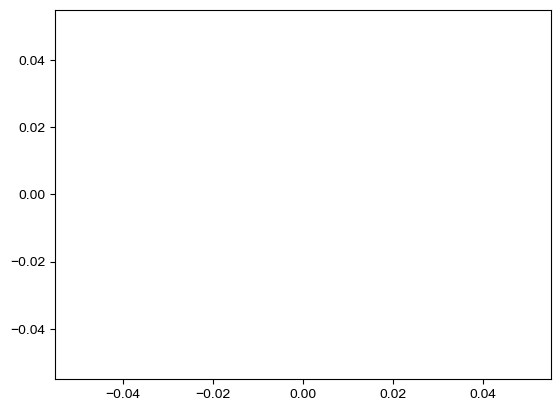

In [53]:
plt.scatter(averaged_omission_pc[0], averaged_omission_pc[1], c=averaged_omission_pc["index"], cmap='Reds')
plt.scatter(averaged_rewarded_pc[0], averaged_rewarded_pc[1], c=averaged_rewarded_pc["index"], cmap='Greens')

plt.show()

In [54]:
all_categories = sorted(pc_product["outcome_and_when"].unique())

In [55]:
all_categories = [category for category in all_categories if not "-10" in category]

In [56]:
all_categories

['-5s to 0s Loss',
 '-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '-5s to 0s Win',
 '0s to 4s Loss',
 '0s to 4s Omission',
 '0s to 4s Rewarded',
 '0s to 4s Win',
 '4s to 5s Loss',
 '4s to 5s Omission',
 '4s to 5s Rewarded',
 '4s to 5s Win',
 '5s to 9s Loss',
 '5s to 9s Omission',
 '5s to 9s Rewarded',
 '5s to 9s Win',
 '9s to 10s Loss',
 '9s to 10s Omission',
 '9s to 10s Rewarded',
 '9s to 10s Win']

win: blue
loss: yellow
rewarded: green
omission: red

In [57]:
all_colors = ["gold", "pink", "lightgreen", "lightblue", "orange", "red", "green", "cyan", "darkorange", "darkred", "darkgreen", "darkcyan"]


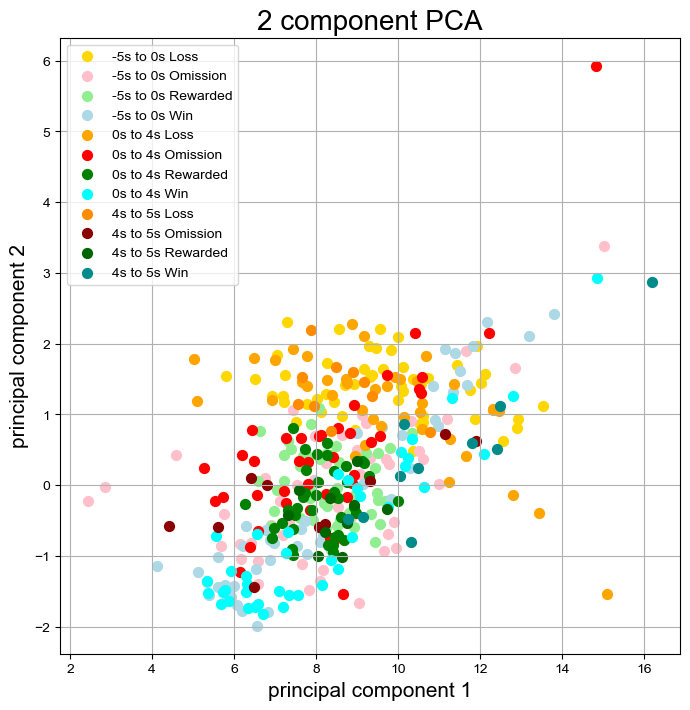

In [58]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(all_categories, all_colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(all_categories)
ax.grid()

## Looking at each plot individually across time

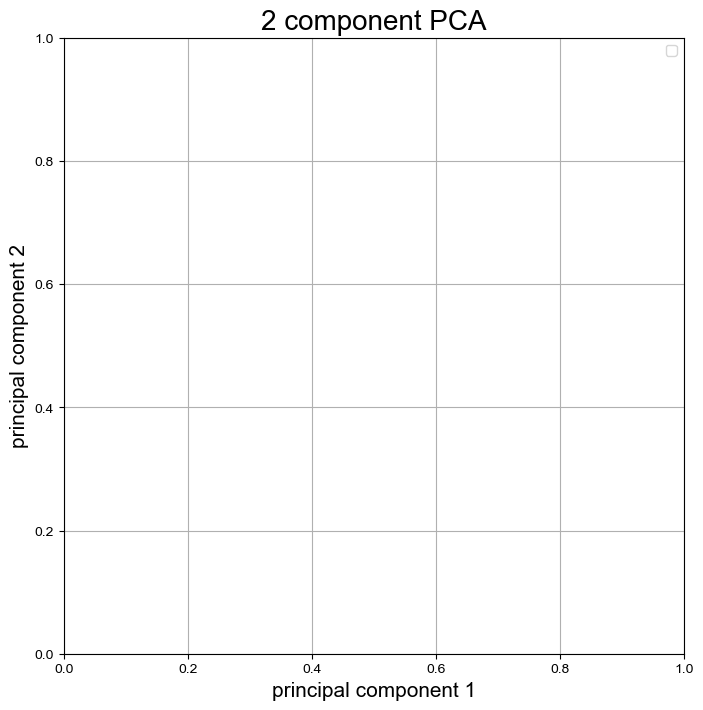

In [59]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

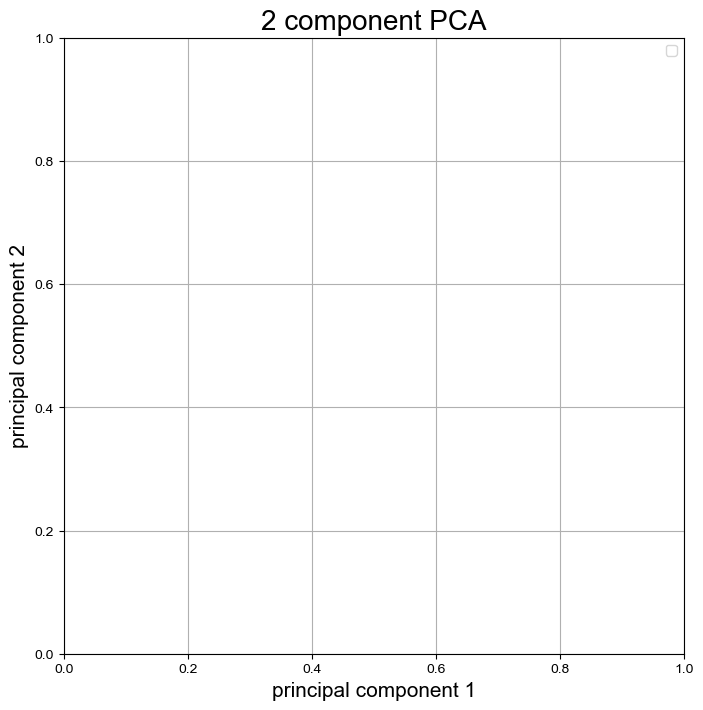

In [60]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightgreen", "green", "darkgreen"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

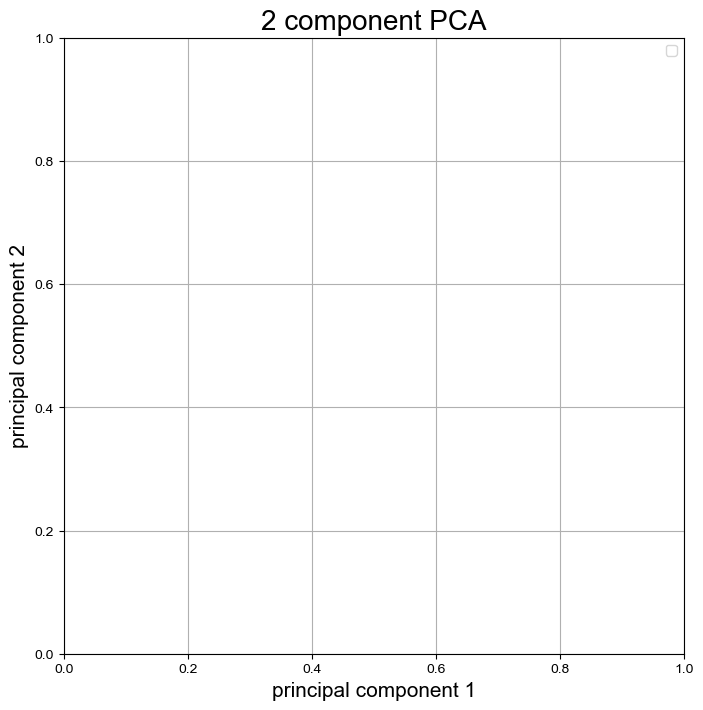

In [61]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = win_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

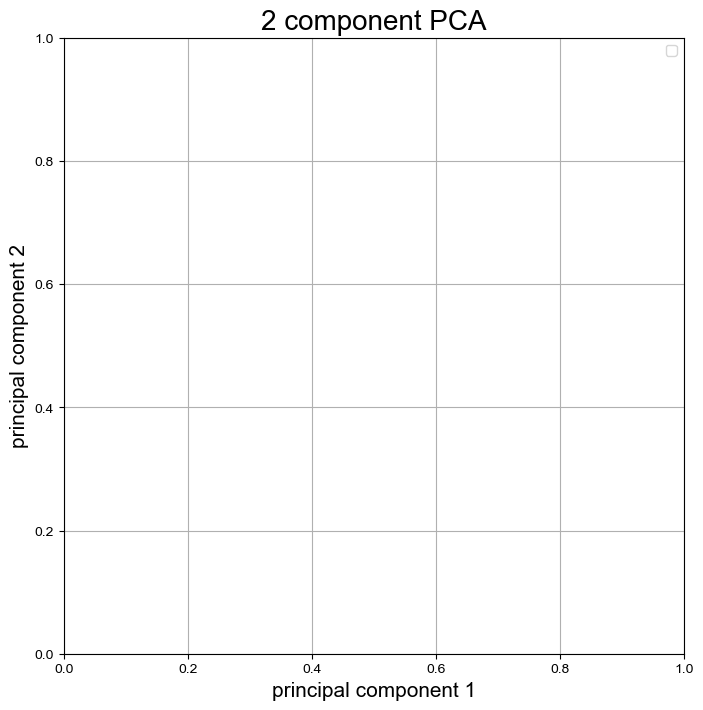

In [62]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = loss_categories
colors = ["gold", "orange", "darkorange"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Comparing all trials with each time frame

In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


In [64]:
pclabcol = ['#15616F','#FFAF00', '#792910','#001424']
#15616F: Dark Turqoise: Win
#FFAF00: Golden Yellow: Rewarded
#792910: Dark Red/Brown: Loss
#001424: Black Omitted

/tmp/ipykernel_2730888/179461515.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


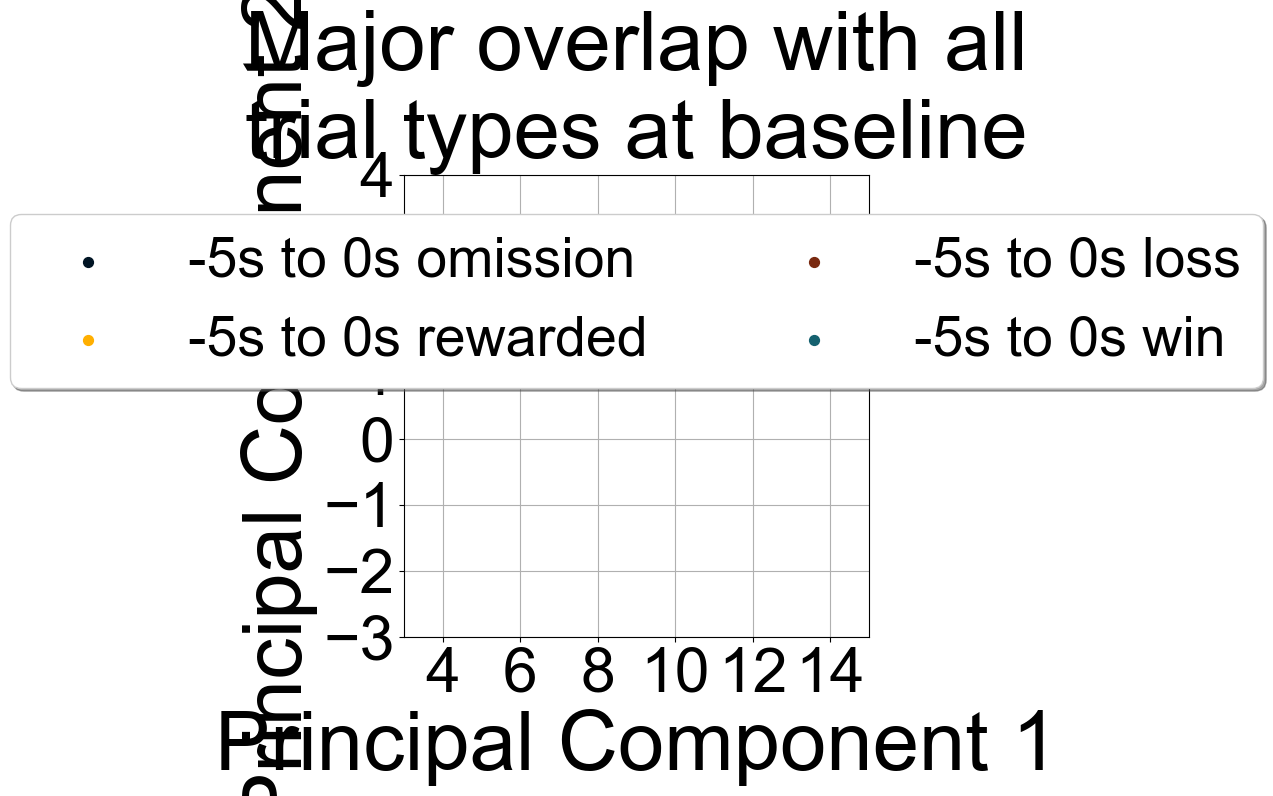

In [65]:
fig, ax = plt.subplots(figsize = (6,6))

targets = ['-5s to 0s omission', '-5s to 0s rewarded', '-5s to 0s loss', '-5s to 0s win']
colors = ["#001424", "#FFAF00", "#792910", "#15616F"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
    
ax.set_title('Major overlap with all\ntrial types at baseline', fontsize = TITLESIZE)
plt.xticks(fontsize=AXESTICKS)
plt.yticks(fontsize=AXESTICKS)
plt.xlabel('Principal Component 1', fontsize = AXESLABEL)
plt.ylabel('Principal Component 2', fontsize = AXESLABEL)
plt.xlim((3, 15))
plt.ylim((-3, 4))

plt.legend(targets, fontsize=LEGSIZE, loc='upper center', bbox_to_anchor=(0.5, 0.975),
          ncol=2, fancybox=True, shadow=True)
plt.tight_layout()
ax.grid()

plt.savefig("./proc/plots/all_trials_-5s_0s.png", bbox_inches='tight')
plt.savefig("./proc/plots/all_trials_-5s_0s.svg", bbox_inches='tight')

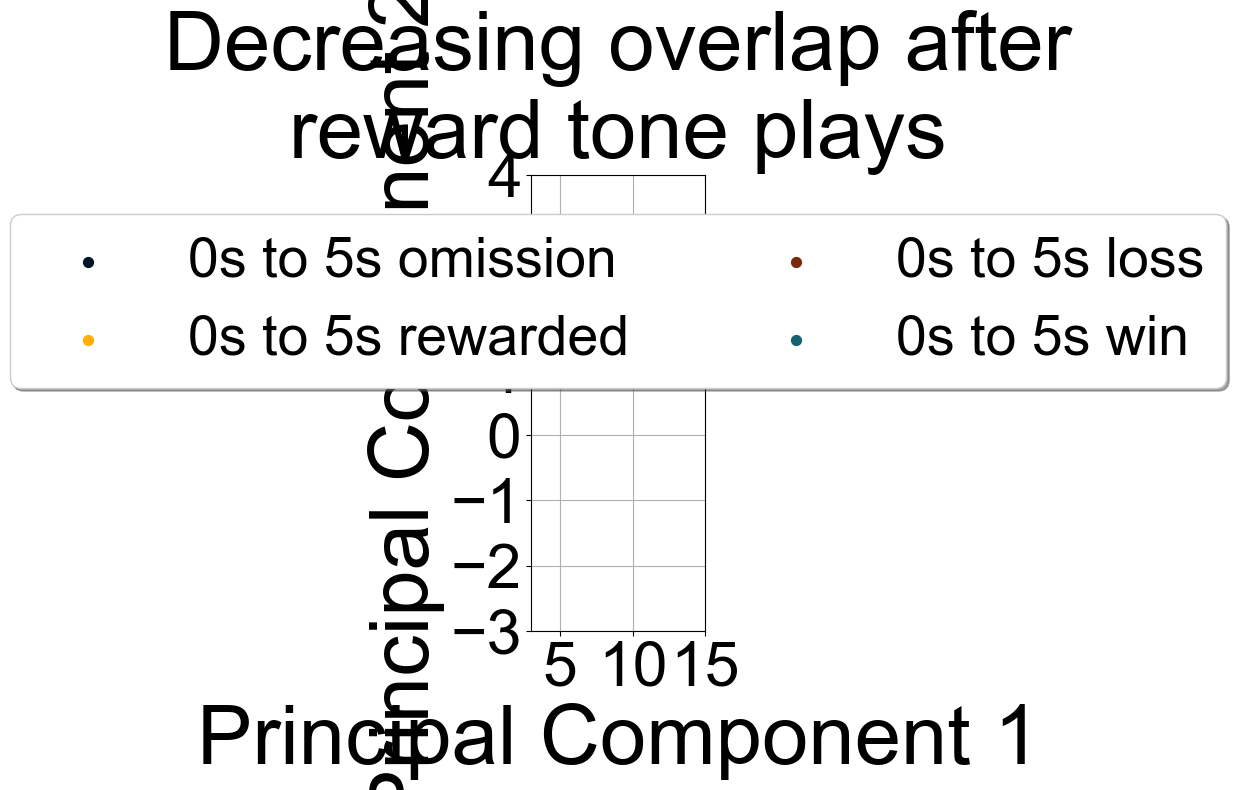

In [66]:
fig, ax = plt.subplots(figsize = (8,8))

targets = ['0s to 5s omission', '0s to 5s rewarded', '0s to 5s loss', '0s to 5s win']
colors = ["#001424", "#FFAF00", "#792910", "#15616F"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
    
ax.set_title('Decreasing overlap after\nreward tone plays', fontsize = TITLESIZE)
plt.xticks(fontsize=AXESTICKS)
plt.yticks(fontsize=AXESTICKS)
plt.xlabel('Principal Component 1', fontsize = AXESLABEL)
plt.ylabel('Principal Component 2', fontsize = AXESLABEL)
plt.xlim((3, 15))
plt.ylim((-3, 4))

plt.legend(targets, fontsize=LEGSIZE, loc='upper center', bbox_to_anchor=(0.5, 0.975),
          ncol=2, fancybox=True, shadow=True)
plt.tight_layout()
ax.grid()

plt.savefig("./proc/plots/all_trials_0s_5s.png", bbox_inches='tight')
plt.savefig("./proc/plots/all_trials_0s_5s.svg", bbox_inches='tight')

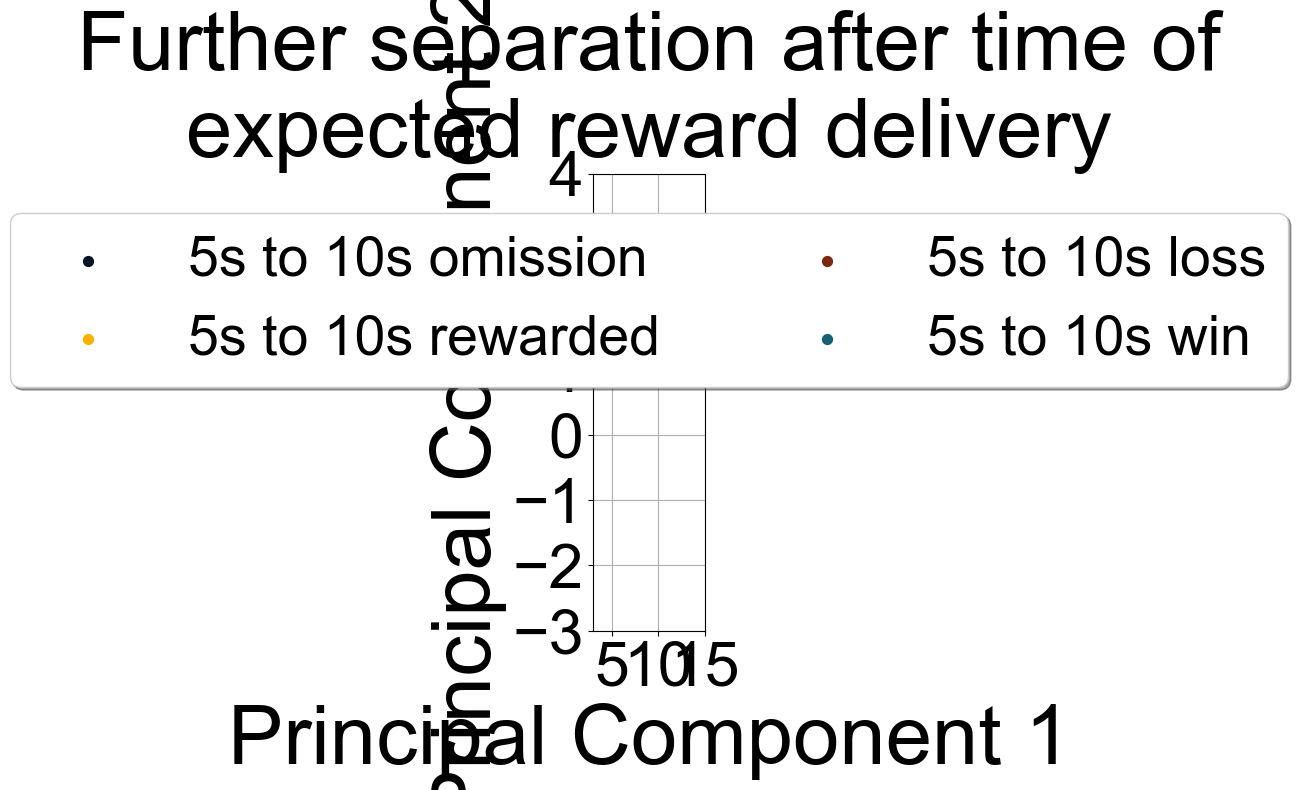

In [67]:
fig, ax = plt.subplots(figsize = (8,8))

targets = ['5s to 10s omission', '5s to 10s rewarded', '5s to 10s loss', '5s to 10s win']
colors = ["#001424", "#FFAF00", "#792910", "#15616F"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
    
ax.set_title('Further separation after time of\nexpected reward delivery', fontsize = TITLESIZE)
plt.xticks(fontsize=AXESTICKS)
plt.yticks(fontsize=AXESTICKS)
plt.xlabel('Principal Component 1', fontsize = AXESLABEL)
plt.ylabel('Principal Component 2', fontsize = AXESLABEL)
plt.xlim((3, 15))
plt.ylim((-3, 4))

plt.legend(targets, fontsize=LEGSIZE, loc='upper center', bbox_to_anchor=(0.5, 0.975),
          ncol=2, fancybox=True, shadow=True)
plt.tight_layout()
ax.grid()

plt.savefig("./proc/plots/all_trials_5s_10s.png", bbox_inches='tight')
plt.savefig("./proc/plots/all_trials_5s_10s.svg", bbox_inches='tight')

# Comparing Omission/Losing and Rewarded/Winning

In [68]:
pclabcol = ['#15616F','#FFAF00', '#792910','#001424']
#15616F: Dark Turqoise: Win
#FFAF00: Golden Yellow: Rewarded
#792910: Dark Red/Brown: Loss
#001424: Black Omitted

In [69]:
mylabels = ['-4s to 0s Omission', '-4s to 0s Loss', '1s to 5s Omission', '1s to 5s Loss']

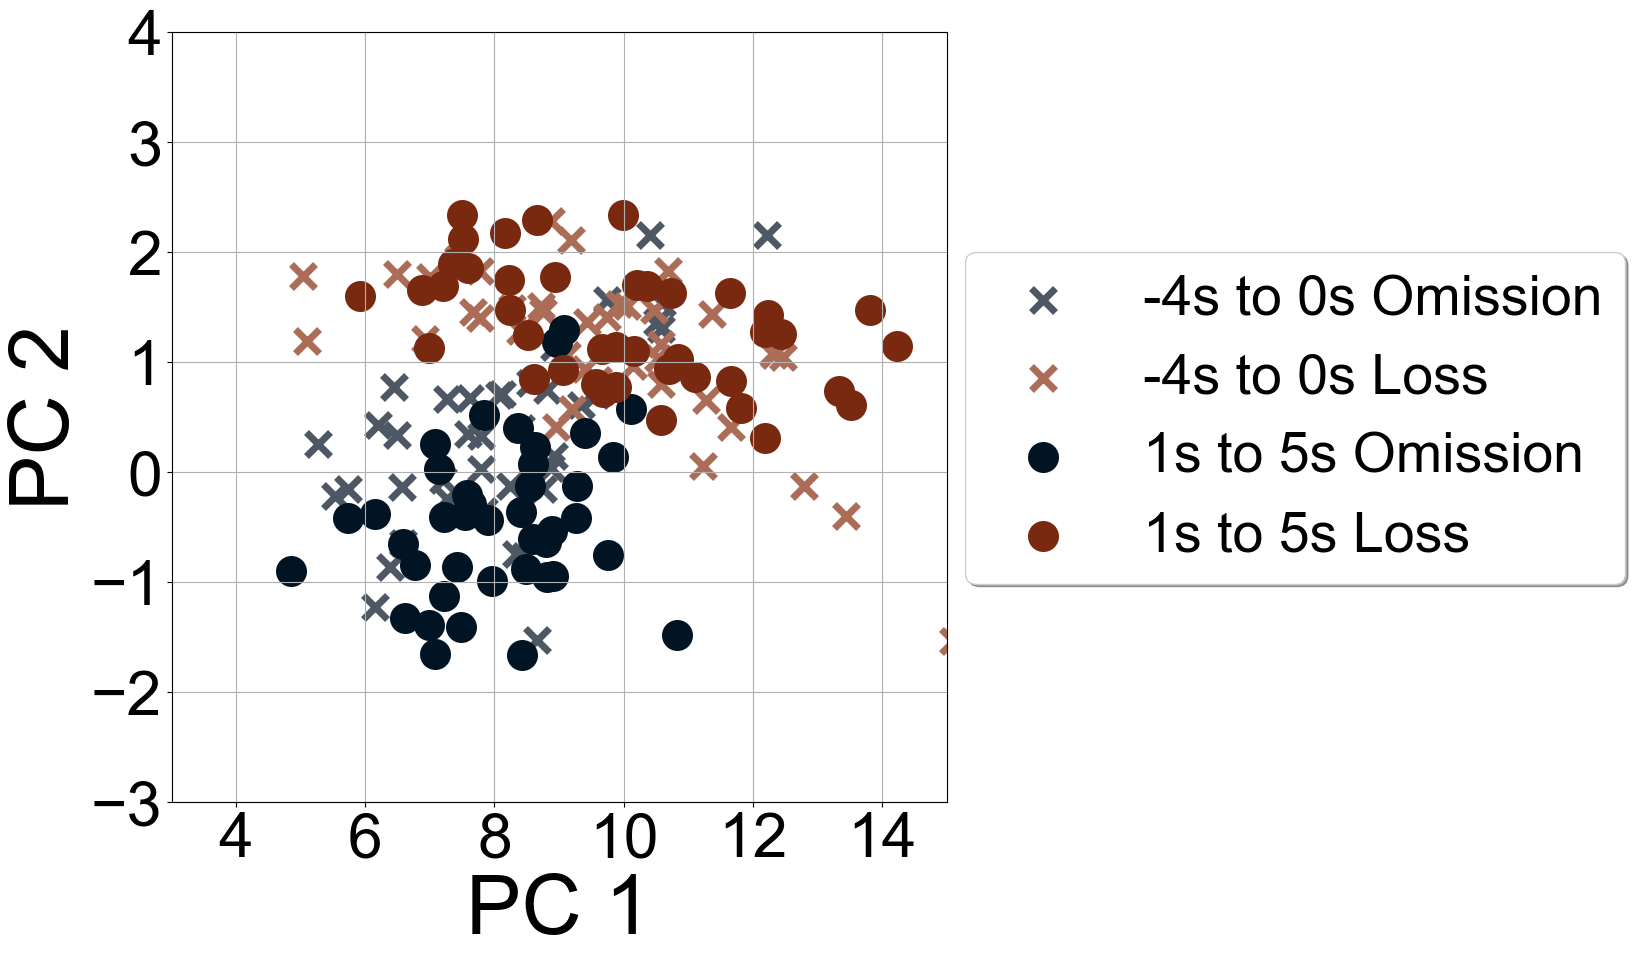

In [70]:
plt.rcParams["figure.figsize"] = (10 * size_ratio, 10 * size_ratio)
fig, ax = plt.subplots()

targets = ['0s to 4s Omission', '0s to 4s Loss', '5s to 9s Omission', '5s to 9s Loss']
colors = ["#4e5865", "#ac6d58", "#001424", "#792910"]
shapes = ["x", "x", "o", "o"]
for target, color, marker in zip(targets,colors, shapes):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , s = MARKERSIZE
               , c = color
              , marker=marker,
               linewidths=LINWID)
    
# ax.set_title('Separation with\nomission and loss\nwith no shift over time', fontsize = TITLESIZE)
plt.xticks(fontsize=AXESTICKS)
plt.yticks(fontsize=AXESTICKS)
plt.xlabel('PC 1', fontsize = AXESLABEL)
plt.ylabel('PC 2', fontsize = AXESLABEL)
plt.xlim((3, 15))
plt.ylim((-3, 4))

plt.legend(labels=mylabels, fontsize=LEGSIZE, loc='upper center',
          ncol=1, fancybox=True, shadow=True, columnspacing=0.0, bbox_to_anchor=(1.45, 0.75))

ax.grid()

plt.savefig("./proc/plots/om_and_loss_trials_baseline_and_after_tone.png", bbox_inches='tight')
plt.savefig("./proc/plots/om_and_loss_trials_baseline_and_after_tone.svg", bbox_inches='tight')

In [71]:
mylabels = ['-4s to 0s Rewarded', '-4s to 0s Win', '1s to 5s Rewarded', '1s to 5s Win']

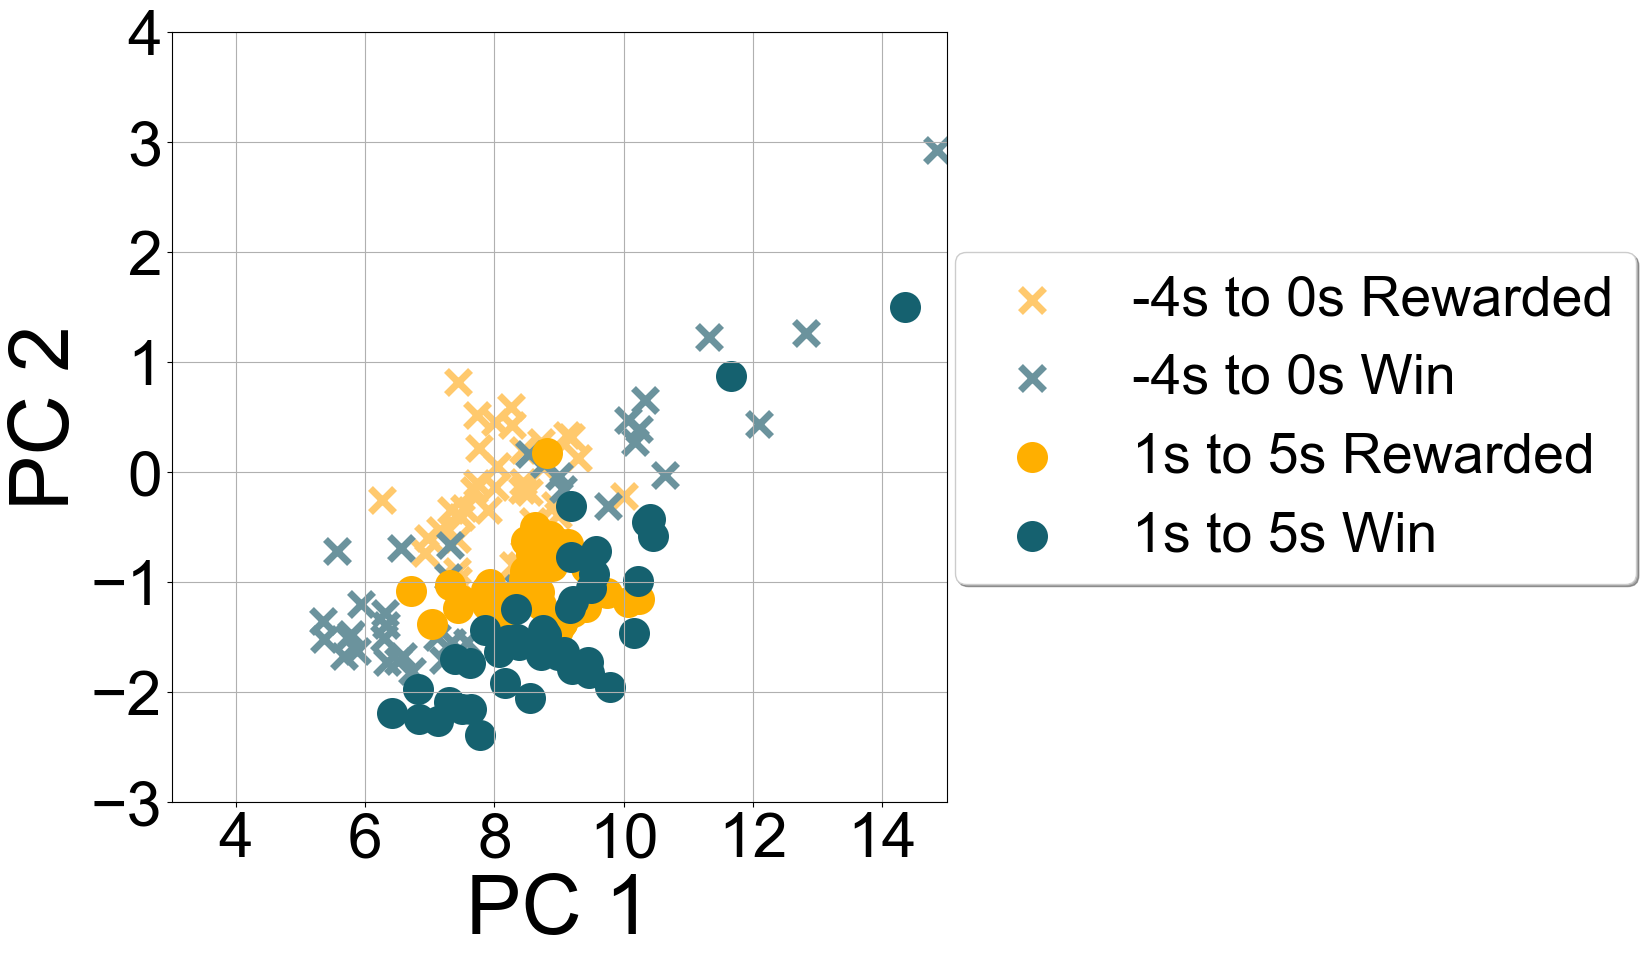

In [76]:
plt.rcParams["figure.figsize"] = (10 * size_ratio, 10 * size_ratio)

fig, ax = plt.subplots()

targets = ['0s to 4s Rewarded', '0s to 4s Win', '5s to 9s Rewarded', '5s to 9s Win']
colors = ["#ffc96d", "#6b939d", "#FFAF00", "#15616F"]
shapes = ["x", "x", "o", "o"]
for target, color, marker in zip(targets,colors, shapes):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , s = MARKERSIZE
               , c = color
              , marker=marker,
               linewidths=LINWID)
    
# ax.set_title('Overlap between\nwin and reward\nwith shift over time', fontsize = TITLESIZE)
# ax.set_title('Win and reward\nexpectation overlap with\na shift over time', fontsize = TITLESIZE)

plt.xticks(fontsize=AXESTICKS)
plt.yticks(fontsize=AXESTICKS)
plt.xlabel('PC 1', fontsize = AXESLABEL)
plt.ylabel('PC 2', fontsize = AXESLABEL)
plt.xlim((3, 15))
plt.ylim((-3, 4))

plt.legend(labels=mylabels, fontsize=LEGSIZE, loc='upper center',
          ncol=1, fancybox=True, shadow=True, columnspacing=0.0, bbox_to_anchor=(1.45, 0.75))
# plt.tight_layout()
ax.grid()

plt.savefig("./proc/plots/reward_and_win_trials_baseline_and_after_tone.png", bbox_inches='tight')
plt.savefig("./proc/plots/reward_and_win_trials_baseline_and_after_tone.svg", bbox_inches='tight')

In [73]:
"
    elif 4 <= floated_x < 5:
        return "4s to 5s"
    elif 5 <= floated_x <= 9:
        return "5s to 9s

SyntaxError: EOL while scanning string literal (2806636086.py, line 1)